<a href="https://colab.research.google.com/github/AMSUCF/DHProgramming/blob/main/BlueSky_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install numpy==1.24.3
!pip install atproto==0.0.61 --no-deps # Install without reinstalling dependencies
!pip install nltk==3.8.1 --no-deps # Install without reinstalling dependencies
!pip install pandas==1.5.3 --no-deps # Install without reinstalling dependencies
!pip install matplotlib==3.7.1 --no-deps # Install without reinstalling dependencies
!pip install seaborn==0.12.2 --no-deps # Install without reinstalling dependencies

from IPython import get_ipython
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2025.3.1 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.3 which is

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 362, in run
    resolver = self.make_resolver(
               ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 177, in make_resolver
    return pip._internal.resolution.resolvelib.resolver.Resolver(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 58, in __init__
    self.factory = Factory(
                   ^^^^^^^^
  File "/usr/local/lib/py

In [19]:
from atproto import Client
import datetime
from google.colab import userdata

# Replace with your Bluesky username and password
BLUESKY_USERNAME = userdata.get('Username')
BLUESKY_PASSWORD = userdata.get('Password')

client = Client()
client.login(BLUESKY_USERNAME, BLUESKY_PASSWORD)

ProfileViewDetailed(did='did:plc:4ji772lj3mrupzidh47uh4za', handle='lucidbard.bsky.social', associated=ProfileAssociated(chat=None, feedgens=0, labeler=False, lists=0, starter_packs=0, py_type='app.bsky.actor.defs#profileAssociated'), avatar='https://cdn.bsky.app/img/avatar/plain/did:plc:4ji772lj3mrupzidh47uh4za/bafkreidapxihe3tq3fvle7mcufsr6wd5huedtb6ebnlmtdz7u6vuv7b4wi@jpeg', banner=None, created_at='2023-08-18T17:37:32.415Z', description='He/him. Assoc. Professor of Games and Digital Media, UCF. Co-PI NSF Virtual Experience Research Accelerator. VR, AI, Interactive Narratives, Authoring Platforms. Co-author of Flash: Building the Interactive Web, Adventure Games: Playing the Outsider', display_name='John T. Murray', followers_count=504, follows_count=235, indexed_at='2024-11-16T14:05:05.518Z', joined_via_starter_pack=None, labels=[], pinned_post=None, posts_count=17, verification=None, viewer=ViewerState(blocked_by=False, blocking=None, blocking_by_list=None, followed_by=None, follo

In [12]:
def fetch_public_posts(client, query, limit=100):
    """Fetches public posts containing a query."""
    all_posts = []
    cursor = None

    while len(all_posts) < limit:
        # Create the params dictionary
        params = {
            'q': query,
            'limit': min(100, limit - len(all_posts)),  # Adjust limit
        }
        if cursor:
            params['cursor'] = cursor # Add cursor if available

        response = client.app.bsky.feed.search_posts(params)

        if not response.posts:
            break  # No more posts found

        for post in response.posts:
            all_posts.append({
                'text': post.record.text,
                'date': datetime.datetime.fromisoformat(post.record.created_at.replace('Z', '+00:00'))
            })

        cursor = response.cursor
        if not cursor:
            break  # No more pages

    return all_posts

# You can adjust the limit to fetch more posts
query = "AI"
posts = fetch_public_posts(client, query, limit=1000)

print(f"Found {len(posts)} public posts containing '{query}'.")

Found 1000 public posts containing 'AI'.


In [14]:
import json
import datetime

# Assuming 'posts' is the list of dictionaries containing the fetched posts

def save_posts_to_json(posts_list, filename="bluesky_posts.json"):
    """Saves a list of posts to a JSON file."""
    # Convert datetime objects to string format for JSON serialization
    serializable_posts = []
    for post in posts_list:
        serializable_post = post.copy() # Create a copy to avoid modifying the original list
        if isinstance(serializable_post.get('date'), datetime.datetime):
            serializable_post['date'] = serializable_post['date'].isoformat()
        serializable_posts.append(serializable_post)

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(serializable_posts, f, indent=4) # Use indent for readability

# Call the function to save the posts
save_posts_to_json(posts, filename="ai_bluesky_posts.json")

print(f"Saved {len(posts)} posts to ai_bluesky_posts.json")

Saved 1000 posts to ai_bluesky_posts.json


In [17]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except Exception: # Catch a more general exception
    nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def analyze_sentiment(posts_list):
    """Analyzes the sentiment of a list of posts."""
    sentiments = []
    for post in posts_list:
        sentiment_scores = sia.polarity_scores(post['text'])
        sentiments.append({
            'text': post['text'],
            'date': post['date'],
            'compound_sentiment': sentiment_scores['compound']
        })
    return sentiments

post_sentiments = analyze_sentiment(posts)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(post_sentiments)


Sentiment Distribution:
count    1000.000000
mean        0.082236
std         0.409272
min        -0.965200
25%         0.000000
50%         0.000000
75%         0.361550
max         0.962000
Name: compound_sentiment, dtype: float64

Sentiment Categories Count:
Neutral     442
Positive    343
Negative    215
Name: sentiment_category, dtype: int64


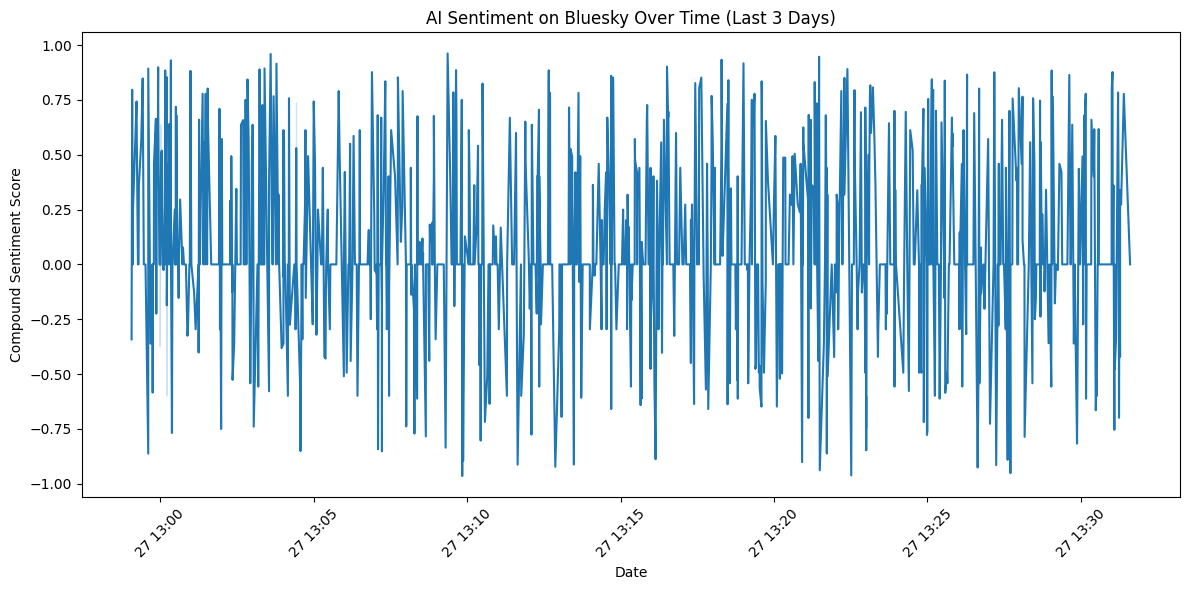

In [18]:
# Basic sentiment distribution
print("\nSentiment Distribution:")
print(df['compound_sentiment'].describe())

# You can categorize sentiment based on compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['compound_sentiment'].apply(categorize_sentiment)

print("\nSentiment Categories Count:")
print(df['sentiment_category'].value_counts())

# Visualize sentiment over time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='compound_sentiment')
plt.title('AI Sentiment on Bluesky Over Time (Last 3 Days)')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# You can also explore word frequencies, topics, etc., but those require more advanced NLP techniques.